In [ ]:
# <-- Import libraries, custom functions, and load configuration & datasets <-- #

import yaml
import datetime as dt
import re
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import seaborn as sns

from statsmodels.multivariate.manova import MANOVA
from scipy import stats
from scipy.stats import pearsonr, boxcox, chi2_contingency
from scipy.stats.contingency import association

# <-- Imports custom preprocessing functions from 'functions.py' <-- #

# from functions import ()

# <-- Loads YAML configuration to dynamically reference CSV output files. <-- #

config = None  # <-- Initialize config
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")


df_demo = pd.read_csv(config['input_data']['file1'])
df_exp_clients = pd.read_csv(config['input_data']['file2'])
df_web_data_pt_1 = pd.read_csv(config['input_data']['file3'])
df_web_data_pt_2 = pd.read_csv(config['input_data']['file3'])

In [4]:
df_demo

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0


In [5]:
df_exp_clients

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


In [6]:
display(pd.DataFrame({
    "non_nulls": df_exp_clients.count(),
    "nulls": df_exp_clients.isnull().sum(),
    "total": len(df_exp_clients)
}))

,non_nulls,nulls,total
client_id,70609,0,70609
Variation,50500,20109,70609


In [7]:
df_exp_clients.dropna(inplace=True)

In [8]:
# Drop rows of clients not inlcuded in the experiment
df_exp_clients.shape, df_exp_clients.isnull().sum()

((50500, 2),
 client_id    0
 Variation    0
 dtype: int64)

In [9]:
# client_id == 4666211 [only client with not age]
df_exp_clients[df_exp_clients['client_id'] == 4666211]

,client_id,Variation
38552,4666211,Control


In [10]:
df_web_data_pt_1

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
343136,2443347,465784886_73090545671,136329900_10529659391_316129,confirm,2017-03-31 15:15:46
343137,2443347,465784886_73090545671,136329900_10529659391_316129,step_3,2017-03-31 15:14:53
343138,2443347,465784886_73090545671,136329900_10529659391_316129,step_2,2017-03-31 15:12:08
343139,2443347,465784886_73090545671,136329900_10529659391_316129,step_1,2017-03-31 15:11:37


In [11]:
df_web_data_pt_2

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
343136,2443347,465784886_73090545671,136329900_10529659391_316129,confirm,2017-03-31 15:15:46
343137,2443347,465784886_73090545671,136329900_10529659391_316129,step_3,2017-03-31 15:14:53
343138,2443347,465784886_73090545671,136329900_10529659391_316129,step_2,2017-03-31 15:12:08
343139,2443347,465784886_73090545671,136329900_10529659391_316129,step_1,2017-03-31 15:11:37


In [12]:
# Concatenate the two web data parts vertically and drop duplicates
df_web_data = pd.concat([df_web_data_pt_1, df_web_data_pt_2], ignore_index=True).drop_duplicates().reset_index(drop=True)
print(f"Combined shape: {df_web_data.shape}")
print(f"Original shapes: {df_web_data_pt_1.shape} + {df_web_data_pt_2.shape}")
df_web_data

Combined shape: (341046, 5)
Original shapes: (343141, 5) + (343141, 5)


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
341041,2443347,465784886_73090545671,136329900_10529659391_316129,confirm,2017-03-31 15:15:46
341042,2443347,465784886_73090545671,136329900_10529659391_316129,step_3,2017-03-31 15:14:53
341043,2443347,465784886_73090545671,136329900_10529659391_316129,step_2,2017-03-31 15:12:08
341044,2443347,465784886_73090545671,136329900_10529659391_316129,step_1,2017-03-31 15:11:37


In [13]:
df_demo.columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'],
      dtype='object')

In [14]:
df_exp_clients.columns

Index(['client_id', 'Variation'], dtype='object')

In [15]:
# Counting and sorting the unique values for each numerical column in descending order
df_demo.select_dtypes("number").nunique().sort_values(ascending=False)

client_id           70609
bal                 70328
clnt_tenure_mnth      482
clnt_age              165
clnt_tenure_yr         54
logons_6_mnth           9
num_accts               8
calls_6_mnth            8
dtype: int64

In [16]:
display(pd.DataFrame({
    "non_nulls": df_demo.count(),
    "nulls": df_demo.isnull().sum(),
    "total": len(df_demo)
}))

,non_nulls,nulls,total
client_id,70609,0,70609
clnt_tenure_yr,70595,14,70609
clnt_tenure_mnth,70595,14,70609
clnt_age,70594,15,70609
gendr,70595,14,70609
num_accts,70595,14,70609
bal,70595,14,70609
calls_6_mnth,70595,14,70609
logons_6_mnth,70595,14,70609


In [17]:
# Drop the rows are missing elements.
df_demo.dropna(thresh=7, inplace=True)

In [18]:
df_demo.shape, df_demo.isnull().sum()

((70595, 9),
 client_id           0
 clnt_tenure_yr      0
 clnt_tenure_mnth    0
 clnt_age            1
 gendr               0
 num_accts           0
 bal                 0
 calls_6_mnth        0
 logons_6_mnth       0
 dtype: int64)

In [19]:
df_demo.drop_duplicates(subset='client_id').count()

client_id           70595
clnt_tenure_yr      70595
clnt_tenure_mnth    70595
clnt_age            70594
gendr               70595
num_accts           70595
bal                 70595
calls_6_mnth        70595
logons_6_mnth       70595
dtype: int64

In [20]:
display(pd.DataFrame({
    "non_nulls": df_exp_clients.count(),
    "nulls": df_exp_clients.isnull().sum(),
    "total": len(df_exp_clients)
}))

,non_nulls,nulls,total
client_id,50500,0,50500
Variation,50500,0,50500


In [21]:
# Calculate the mean, median, mode, variance, and standard deviation of 'clnt_age'.
data={"mean": [df_demo['clnt_age'].mean()], "median": [df_demo['clnt_age'].median()],
 "mode": [df_demo['clnt_age'].mode()[0]], "sd": [df_demo['clnt_age'].std()]}
display(pd.DataFrame(data))

,mean,median,mode,sd
0,46.44224,47.0,58.5,15.591273


In [22]:
# Discretizing 'clnt_age' into quartiles
df_demo['clnt_age_quantile'] = pd.qcut(df_demo['clnt_age'], q=4, labels=['A1', 'A2', 'A3', 'A4'])
df_demo.clnt_age_quantile.value_counts()

clnt_age_quantile
A3    18041
A1    17853
A2    17674
A4    17026
Name: count, dtype: int64

In [23]:
# Show rows that have at least one missing value
df_demo[df_demo.isnull().any(axis=1)]

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,clnt_age_quantile
9583,4666211,8.0,106.0,NaN,F,2.0,42550.55,4.0,7.0,NaN


In [24]:
#df_demo.groupby('tenure_quantile')['clnt_age'].agg('median')

# sns.boxplot(x=new_df['clnt_age'], color="lightblue")
# plt.show()

In [25]:
df_demo.groupby("clnt_age_quantile")['clnt_age'].agg(['mean','median','std'])

C:\Users\pablo\AppData\Local\Temp\ipykernel_25856\2651193523.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_demo.groupby("clnt_age_quantile")['clnt_age'].agg(['mean','median','std'])


,mean,median,std
clnt_age_quantile,,,
A1,26.464992,27.0,4.046262
A2,39.978301,40.0,4.273162
A3,53.421401,53.5,3.386708
A4,66.704569,65.5,5.966074


In [26]:
df_demo['clnt_age'].describe()

count    70594.000000
mean        46.442240
std         15.591273
min         13.500000
25%         32.500000
50%         47.000000
75%         59.000000
max         96.000000
Name: clnt_age, dtype: float64

In [27]:
desc = df_demo['clnt_age'].describe()
# desc['std'], desc['min'], desc['max'], desc['25%'], desc['75%']
variance = round(df_demo['clnt_age'].var(), 2)
std_dev = round(df_demo['clnt_age'].std(), 2)
price_range = (desc['min'], desc['max'])
iqr = desc['75%'] - desc['25%']

print(f'Age Variance: {variance}')
print(f"Age Std Deviation: {std_dev}")
print(f'Age Range: {price_range}')
print(f"Age Interquartile Range: {iqr}")

Age Variance: 243.09
Age Std Deviation: 15.59
Age Range: (np.float64(13.5), np.float64(96.0))
Age Interquartile Range: 26.5


In [28]:
skewness_age = round(df_demo['clnt_age'].skew())
kurtosis_age = round(df_demo['clnt_age'].kurtosis())

skewness_age, kurtosis_age

(0, -1)

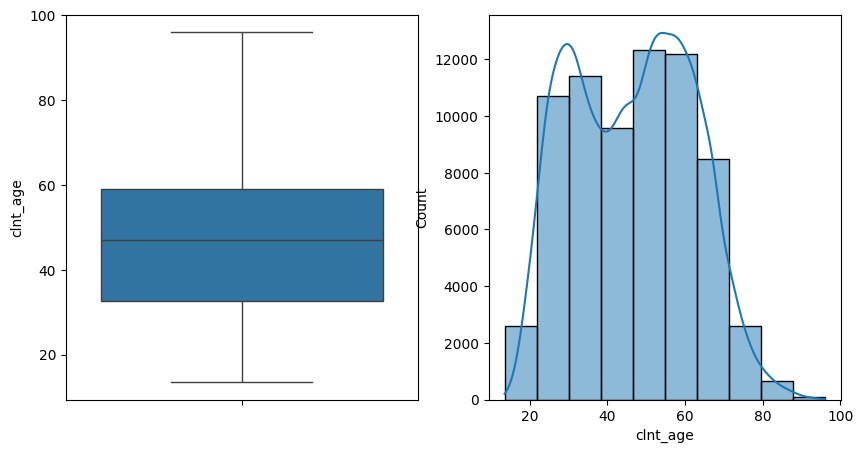

In [29]:
# Age distribution
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(data=df_demo, y='clnt_age',ax=axes[0])
sns.histplot(df_demo['clnt_age'], kde=True, bins=10, ax=axes[1]);
plt.show()

In [30]:
df_demo['gendr'].unique()

array(['U', 'M', 'F', 'X'], dtype=object)

In [31]:
df_demo['gendr'].value_counts(dropna=False)

gendr
U    24122
M    23724
F    22746
X        3
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='gendr_clean'>

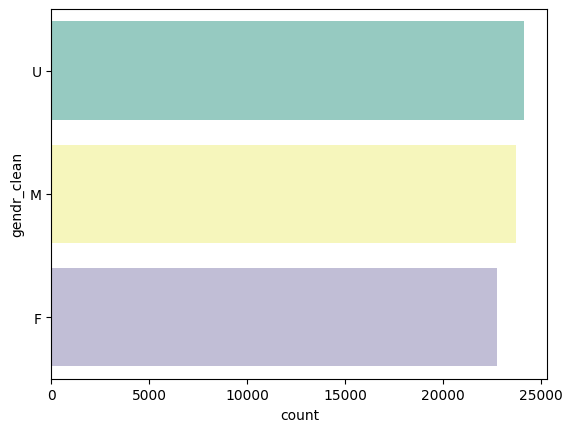

In [32]:
df_demo['gendr_clean'] = df_demo['gendr'].apply(lambda x: x if x in ['M', 'F'] else 'U')
sns.countplot(data=df_demo, y='gendr_clean', palette="Set3", hue='gendr_clean', legend=False)

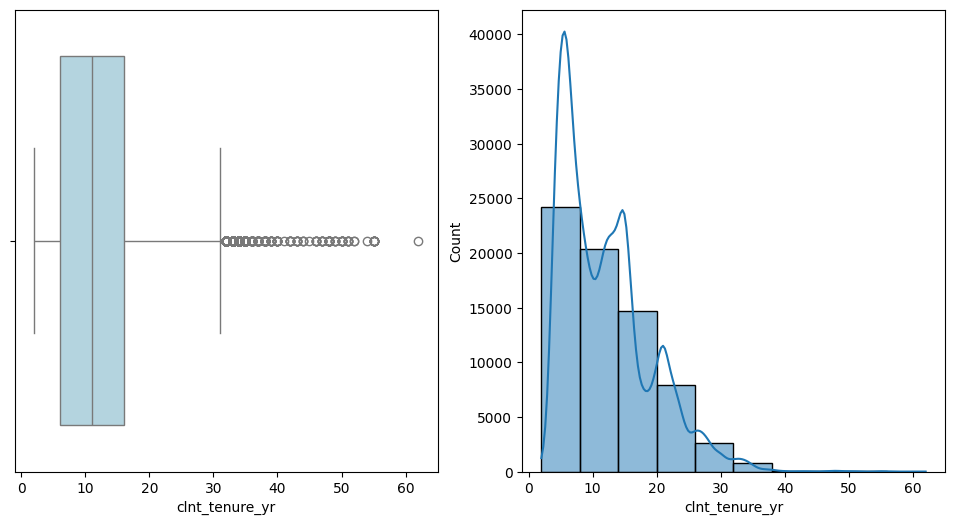

In [33]:
# Gender distribution
fig, axes = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(x = df_demo['clnt_tenure_yr'], color="lightblue", ax=axes[0])
sns.histplot(df_demo['clnt_tenure_yr'], bins=10, kde=True, ax=axes[1]);
plt.show()

In [34]:
# Cross-tab age quantiles with tenure quantiles (Are younger clients newer? Are older clients more tenured?)
df_demo['tenure_quantile'] = pd.qcut(df_demo['clnt_tenure_yr'], q=4, labels=['T1','T2','T3','T4'])
crosstab_result = pd.crosstab(df_demo['clnt_age_quantile'], df_demo['tenure_quantile'])
crosstab_result

tenure_quantile,T1,T2,T3,T4
clnt_age_quantile,,,,
A1,7976,5339,2867,1671
A2,4180,4736,5881,2877
A3,3980,4212,5011,4838
A4,3128,3764,4403,5731


In [35]:
# Correlation
df_demo[['clnt_age', 'clnt_tenure_yr']].corr()

,clnt_age,clnt_tenure_yr
clnt_age,1.000000,0.309372
clnt_tenure_yr,0.309372,1.000000


In [36]:
# Calculating the Pearson correlation 'Age' and 'Tenure'
person_correlation = df_demo['clnt_age'].corr(df_demo['clnt_tenure_yr'])
person_correlation

np.float64(0.30937245195041824)

In [37]:
# Calculating the Spearman rank correlation 'Age' and 'Tenure'
spearman_correlation = df_demo['clnt_age'].corr(df_demo['clnt_tenure_yr'], method='spearman')
spearman_correlation

np.float64(0.30097573143540785)

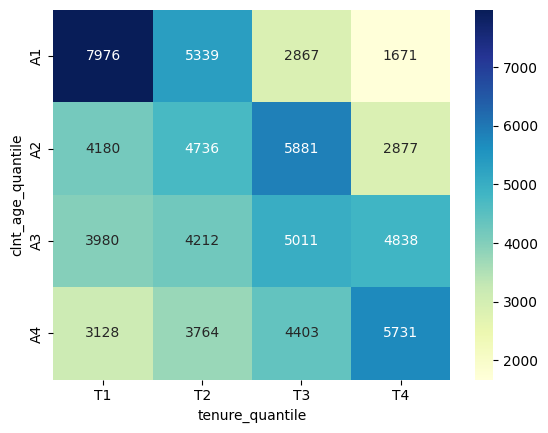

In [38]:
sns.heatmap(crosstab_result, annot=True, cmap="YlGnBu", fmt="d");

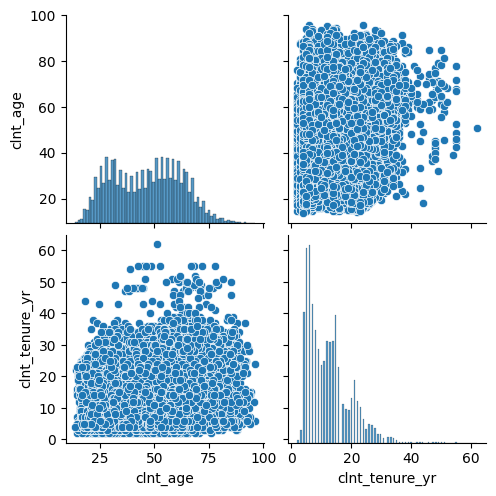

In [47]:
sns.pairplot(df_demo[["clnt_age", "clnt_tenure_yr"]]);